In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch import device
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("/content/drive/MyDrive/Cours/ensta cours/CSC_5IA23_TA_Project-main/")
from ResNet import ResNet18
torch.manual_seed(47)
np.random.seed(47)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
data = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=tr
)
batch_size = 32
train_size = int(0.9* len(data))
val_size = int(0.1*len(data))
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Neural Collapse

### separating the data per class

In [4]:
def load_model(path):
    d = torch.load(path)
    d["cl.weight"] = d["model.13.weight"]
    d["cl.bias"] = d["model.13.bias"]
    d.pop("model.13.weight")
    d.pop("model.13.bias")
    resnet = ResNet18(64,2,100).to(device)
    resnet.load_state_dict(d)
    return resnet
# resnet = load_model("/content/drive/MyDrive/Cours/ensta cours/model/resnet_360_epoch.pth")

In [5]:
def compute_features(path,dataloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  resnet = load_model(path)
  resnet.eval()
  features = torch.tensor([],requires_grad=False,device=device)
  l = torch.tensor([],requires_grad=False,device=device)
  pred = torch.tensor([],requires_grad=False,device=device)
  with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = resnet.model(inputs)
        features = torch.cat((features,out))
        l = torch.cat((l,labels))
        pred = torch.cat((pred,torch.argmax(resnet.cl(out),dim=1)))
  W = resnet.cl.weight.data
  del resnet
  return features, l, W, pred


def get_mu_G(features):
  return torch.mean(features,dim=0).to(device)

def get_sigma_T(features,mu_G):
  t = features - mu_G
  t = t.T @ t / (features.shape[0])
  return t
  # return (features.T @ features) / (features.shape[0])

def get_sigma_B(mu_C_list,mu_G):
  sigma_B = torch.zeros((mu_G.shape[0],mu_G.shape[0]),device=device)
  for mu_C in mu_C_list:
    diff = mu_C - mu_G
    sigma_B += diff.unsqueeze(1) @ diff.unsqueeze(0) # Corrected outer product
  sigma_B /= len(mu_C_list)
  return sigma_B

def get_mu_C_list(features,labels):
  mu_C_list = []
  for i in range(100):
    mu_C_list.append(torch.mean(features[labels == i],dim=0).to(device))
  return mu_C_list

## NC 1

variability collapse : In class variations converges towards 0.



In [6]:
def nc1(sigma_W):
  return torch.linalg.norm(sigma_W)

def train_class_means_equinorm(mu_C_list,mu_G):
  centered_norms = []
  for key in range(len(mu_C_list)):
    centered_norms.append(torch.linalg.norm(mu_C_list[key] - mu_G))
  #Fig 2
  centered_norms = torch.tensor(centered_norms,device=device)
  return torch.std(centered_norms) / torch.mean(centered_norms)

def train_class_weights_equinorm(weights):
  norm = torch.sum(weights**2,dim=1)
  # print(norm.shape)
  # print(norm)
  #Fig 2
  m = torch.mean(norm)
  s = torch.std(norm)
  # print(m)
  # print(s)
  return  s/m

def scale_invariante_nc1(Sigma_W, Sigma_B):
    """
    Computes the NC1 metric: 1/C * Trace(Sigma_W * pinv(Sigma_B))
    """
    C = Sigma_B.shape[0] # Number of classes
    Sigma_B_pinv = torch.linalg.pinv(Sigma_B, rcond=1e-6)
    # NC1 = 1/C * Trace(Sigma_W @ Sigma_B_pinv)
    nc1_value = torch.trace(Sigma_W @ Sigma_B_pinv) / C

    #Fig 6
    return nc1_value.item()


## NC 2

As training progresses, the standard deviations of the cosines approach zero
indicating equiangularity

\begin{aligned}
    \left| \|\mu_c - \mu_G\|_2 - \|\mu_{c'} - \mu_G\|_2 \right| &\to 0 \quad \forall c, c' \newline
    \langle \tilde{\mu}_c, \tilde{\mu}_{c'} \rangle &\to \frac{C}{C-1} \delta_{c,c'} - \frac{1}{C-1} \quad \forall c, c'
\end{aligned}

In [7]:
def nc2(mu_C_list,mu_G):
  class_cos_sim = []
  for key in range(len(mu_C_list)):
    for key2 in range(len(mu_C_list)):
      if key < key2: #maybe we dont have to this
        continue
      norm=  (mu_C_list[key] -mu_G )@ (mu_C_list[key2] - mu_G)
      norm = norm/(torch.linalg.norm(mu_C_list[key] - mu_G)*torch.linalg.norm(mu_C_list[key2] - mu_G)   )
      class_cos_sim.append(norm)

  class_cos_sim = torch.tensor(class_cos_sim,device=device)
  vals_2 = torch.std(class_cos_sim)
  vals_3 = class_cos_sim + 1/(class_cos_sim.shape[0] - 1)
  vals_3 = torch.mean(vals_3)
  #Fig 3, Fig 4
  return vals_2,vals_3

## NC 3

 Convergence to self-duality:

$$ \left\| \frac{W^T}{\|W|_F} - \frac{\dot M}{\|\dot M|_F}\right\|_F \to 0$$


In [8]:
def nc3(mu_C_list,mu_G,W):
  mu_C_list = torch.stack(mu_C_list) - mu_G
  mu_C_list = mu_C_list / torch.linalg.norm(mu_C_list,dim=1,keepdim=True)

  W = W / torch.linalg.norm(W,dim=0,keepdim=True)

  #Fig 5
  return torch.linalg.norm(mu_C_list.T - W.T)**2

## NC 4
Simplification to NCC
$$ arg\max_{c'} \left< w_{c'}, h \right> + b_{c'} \to \arg\min_{c'} \|h - \mu_{c'}\|_2 $$


In [9]:
def compute_nc4_disagreement(features, mpred, mu_C_list):
    """
    Computes the disagreement between the model's logits and the NCC rule.

    Args:
        features (N, d): Penultimate layer features.
        logits (N, C): Model output (before softmax).
        class_means (C, d): The computed mu_c for each class.

    Returns:
        disagreement_rate (float): Percentage of samples where Model != NCC.
    """
    # 2. Compute NCC predictions using vectorized L2 distance:
    # ||h - mu||^2 = ||h||^2 + ||mu||^2 - 2<h, mu>
    h_squared = torch.sum(features**2, dim=1, keepdim=True)      # (N, 1)
    class_means = torch.stack(mu_C_list)
    mu_squared = torch.sum(class_means**2, dim=1, keepdim=True).T # (1, C)
    distances = h_squared + mu_squared - 2 * (features @ class_means.T)

    ncc_preds = torch.argmin(distances, dim=1)
    disagreement = (mpred != ncc_preds).float().mean()
    # Fig 7
    return disagreement.item()


## NC 5

As training progresses, the clusters of OOD become increasingly orthgonal to the ETF subspace of the ID data.

# Computing NC values

In [12]:
fig2_1,fig2_2, fig3 , fig4 ,fig5, fig6, fig7 =[],[],[],[],[],[],[]
nc1_fig = []
for i in range(10,361,10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = f"/content/drive/MyDrive/Cours/ensta cours/model/resnet_{i}_epoch.pth"
  features,labels,W,pred = compute_features(path,train_dataloader)

  mu_G = get_mu_G(features)
  sigma_T = get_sigma_T(features,mu_G)
  mu_C_list = get_mu_C_list(features,labels)
  sigma_B = get_sigma_B(mu_C_list,mu_G)
  # print("features :",features.shape)
  # print("labels :",labels.shape)
  # print("W :",W.shape)
  # print("pred :",pred.shape)
  # print("mu_G :",mu_G.shape)
  # print("mu_C_list :",len(mu_C_list))
  # print("mu_C_list[0] :",mu_C_list[0].shape)
  # print("sigma_T :",sigma_T.shape)
  # print("sigma_B :",sigma_B.shape)

  nc1_fig.append(nc1(sigma_T-sigma_B).item())
  fig6.append(scale_invariante_nc1(sigma_T-sigma_B,sigma_B))
  fig2_1.append(train_class_means_equinorm(mu_C_list,mu_G).item())
  fig2_2.append(train_class_weights_equinorm(W).item())
  x,y = nc2(mu_C_list,mu_G)
  fig3.append(x.item())
  fig4.append(y.item())
  fig5.append(nc3(mu_C_list,mu_G,W).item())
  fig7.append(compute_nc4_disagreement(features,pred, mu_C_list))

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

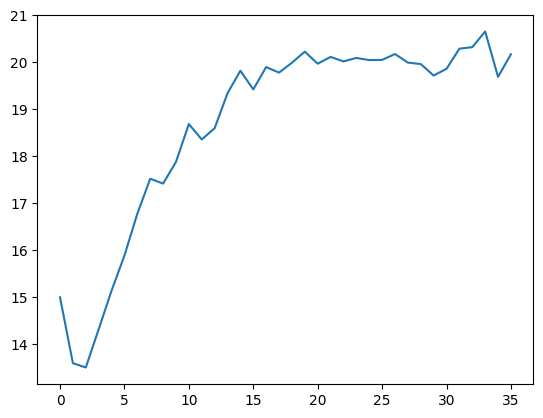

In [15]:
plt.plot(nc1_fig)
plt.show()

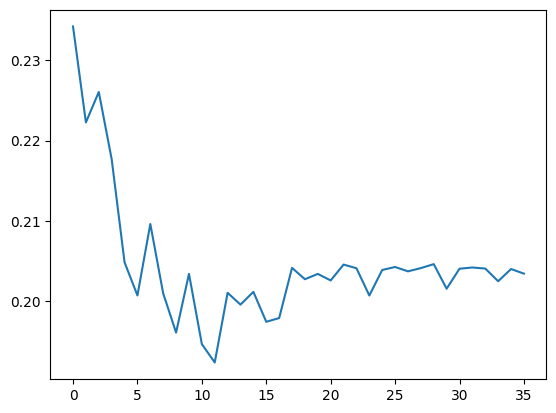

In [16]:
plt.plot(fig2_1)
plt.show()

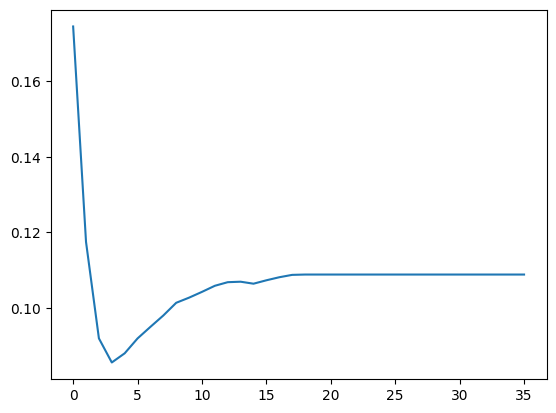

In [17]:
plt.plot(fig2_2)
plt.show()

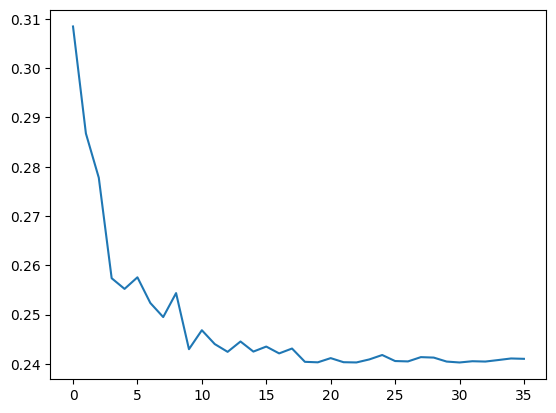

In [18]:
plt.plot(fig3)
plt.show()

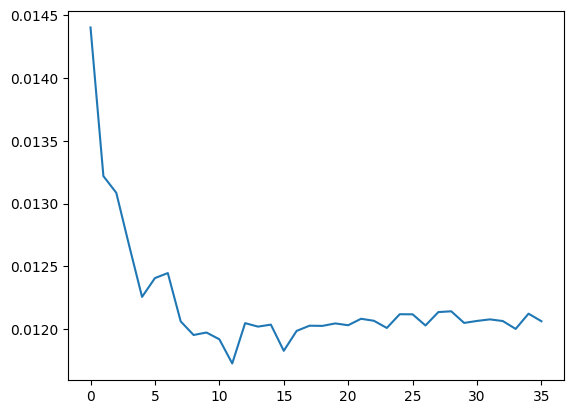

In [19]:
plt.plot(fig4)
plt.show()

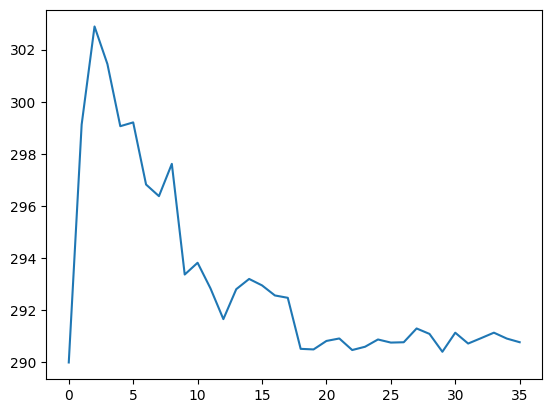

In [20]:
plt.plot(fig5)
plt.show()

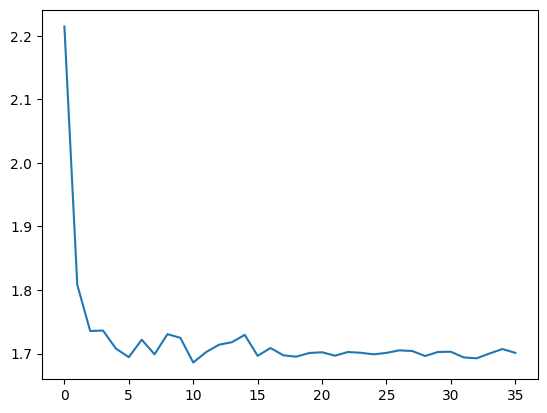

In [21]:
plt.plot(fig6)
plt.show()

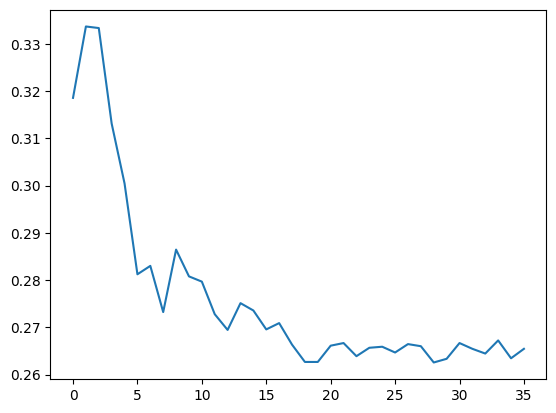

In [22]:
plt.plot(fig7)
plt.show()

In [23]:
import pandas as pd
timeline = [i for i in range(10,361,10)]
df = pd.DataFrame(
    {
        "epochs":timeline,
        "nc1_fig":nc1_fig,
        "fig6_nc1_scale_invariant":fig6,
        "fig2_1_train_class_means_equinorm":fig2_1,
        "fig2_2_train_class_weights_equinorm":fig2_2,
        "fig3_nc2_std_cos_sim":fig3,
        "fig4_nc2_mean_cos_sim":fig4,
        "fig5_nc3":fig5,
        "fig7_nc4_disagreement":fig7
    }
)

In [24]:
df.to_csv("nc_values.csv")